# Generative Adversarial Network

GANs deep neural network is made of two parts:
- A generator: the goal of the generator is to trick the discriminator into thinking the images it generates are real so it learns how to produce realistic images
- A discriminator: the goal of the discriminator is to find images generated by the generator among real images so it learns how to identify real images

These two networks are trained in an adversarial way. At the beginning the generator generates random noise and the discriminator randomly predicts. But overtime the discriminator learns what real images look like and is able to tell which image is real and which image has been generated. To counter that, the generator needs to improve its method, that is to say, it needs to produce ore realistic images.

1. Generator generates images
2. Discriminator tries to identify real images
3. Based on the results of its previous performance, the discriminator sharpen its knowledge about real images
4. Based on the results of the discriminator at guessing, the generator fine-tune its knowledge about generating realistic images
5. Go back to step 1

Note: the generator is similar to the generator part of a (variational) autoencoder.

Note: DCGAN refers to Deep Convolutional GAN, which are commonly called GANs.

It is really easy to create an GAN using Keras Model Subclassing API as show in this [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan).

There are many improvements and variants of GANs.

It is really easy to create an Cycle GAN using Keras Model Subclassing API as show in this [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan).

Let's build an autoencoder "from scratch" to have a better understanding!

## Hand Made Generative Adversarial Network

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, UpSampling2D, Activation, BatchNormalization, Dropout, Conv2DTranspose
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop
from keras.callbacks import Callback, LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.utils import plot_model

# Clear TensorFlow session
K.clear_session()

# Disable eaager execution
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# Tensorflow debugging
# tf.debugging.enable_check_numerics()

import matplotlib.pyplot as plt

2023-11-27 11:43:00.563076: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 11:43:00.626033: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 11:43:00.937717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 11:43:00.937813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 11:43:01.022510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

### Discriminator

In [2]:
class Discriminator():

    def __init__(self,
                 input_dim, discriminator_n_layers, discriminator_conv_filters, discriminator_conv_kernel_sizes, discriminator_conv_strides,
                 discriminator_activation,
                 discriminator_batch_norm_momentum, discriminator_dropout_rate):
        self.input_dim = input_dim
        self.discriminator_n_layers = discriminator_n_layers
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_sizes = discriminator_conv_kernel_sizes
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_activation = discriminator_activation
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.input = Input(shape=self.input_dim, name="discriminator_input")
        
        x = self.input
        for i in range(self.discriminator_n_layers):
            x = Conv2D(filters=self.discriminator_conv_filters[i],
                       kernel_size=self.discriminator_conv_kernel_sizes[i],
                       strides=self.discriminator_conv_kernel_sizes[i],
                       padding="same",
                       kernel_initializer = self.weight_init,
                       name="discriminator_conv_" + str(i))(x)
            
            if self.discriminator_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum=self.discriminator_batch_norm_momentum)(x)

            x = Activation(activation=self.discriminator_activation, name="discriminator_activation_" + str(i))(x)

            if self.discriminator_dropout_rate:
                x = Dropout(rate=self.discriminator_dropout_rate)(x)

        x = Flatten()(x)

        self.output = Dense(1, activation="sigmoid", kernel_initializer=self.weight_init, name="discriminator_output")(x)

        self.model = Model(self.input, self.output, name="discriminator")

    def summary(self):
        self.model.summary()

    def predict(self, x):
        return self.model.predict(x)

### Generator

In [3]:
class Generator():

    def __init__(self,
                 latent_dim, generator_initial_dense_layer_size, generator_n_layers, generator_upsamplings, generator_conv_filters, generator_conv_kernel_sizes, generator_conv_strides,
                 generator_activation,
                 generator_batch_norm_momentum, generator_dropout_rate):
        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_n_layers = generator_n_layers
        self.generator_upsamplings = generator_upsamplings
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_sizes = generator_conv_kernel_sizes
        self.generator_conv_strides = generator_conv_strides
        self.latent_dim = latent_dim
        self.generator_activation = generator_activation
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_dropout_rate = generator_dropout_rate

        self.input = Input(shape=(self.latent_dim,), name="generator_input")

        x = Dense(np.prod(self.generator_initial_dense_layer_size))(self.input) # Connect the input to a dense layer

        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum=self.generator_batch_norm_momentum)(x)

        x = Activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x) # Reshape latent space vector for convolutional transpose layers

        if self.generator_dropout_rate:
            x = Dropout(rate=self.generator_dropout_rate)(x)

        for i in range(self.generator_n_layers):
            if self.generator_upsamplings[i]:
                x = UpSampling2D(name="generator_up_sampling_" + str(i))(x)
                conv_layer = Conv2D(filters=self.generator_conv_filters[i],
                                    kernel_size=self.generator_conv_kernel_sizes[i],
                                    strides=self.generator_conv_strides[i],
                                    padding="same",
                                    name="generator_conv_" + str(i))
                x = conv_layer(x)
            else:
                conv_t_layer = Conv2DTranspose(filters=self.generator_conv_filters[i],
                                               kernel_size=self.generator_conv_kernel_sizes[i],
                                               strides=self.generator_conv_strides[i],
                                               padding="same",
                                               name="generator_conv_t_" + str(i))
                x = conv_t_layer(x)

            if i < self.generator_n_layers - 1:
                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum=self.generator_batch_norm_momentum)(x)
                x = Activation(activation="relu")(x)
            else:
                x = Activation(activation="tanh")(x)

        self.output = x

        self.model = Model(self.input, self.output, name="generator")

    def summary(self):
        self.model.summary()

    def predict(self, x):
        return self.model.predict(x)
        

### Generative Adversarial Network

In [4]:
class GenerativeAdversarialNetwork():

    def __init__(self,
                 input_dim, discriminator_n_layers, discriminator_conv_filters, discriminator_conv_kernel_sizes, discriminator_conv_strides,
                 discriminator_activation, discriminator_learning_rate,
                 discriminator_batch_norm_momentum, discriminator_dropout_rate,
                 latent_dim, generator_initial_dense_layer_size, generator_n_layers, generator_upsamplings, generator_conv_filters, generator_conv_kernel_sizes, generator_conv_strides,
                 generator_activation, generator_learning_rate,
                 generator_batch_norm_momentum, generator_dropout_rate):
        self.input_dim = input_dim
        self.discriminator_n_layers = discriminator_n_layers
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_sizes = discriminator_conv_kernel_sizes
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_activation = discriminator_activation
        self.discriminator_learning_rate = discriminator_learning_rate
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_dropout_rate = discriminator_dropout_rate
        
        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_n_layers = generator_n_layers
        self.generator_upsamplings = generator_upsamplings
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_sizes = generator_conv_kernel_sizes
        self.generator_conv_strides = generator_conv_strides
        self.latent_dim = latent_dim
        self.generator_activation = generator_activation
        self.generator_learning_rate = generator_learning_rate
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_dropout_rate = generator_dropout_rate

        self.epoch = 0
        self.discriminator_losses = []
        self.generator_losses = []

        # Create Discriminator
        self.discriminator = Discriminator(self.input_dim,
                                            self.discriminator_n_layers, self.discriminator_conv_filters, self.discriminator_conv_kernel_sizes, self.discriminator_conv_strides,
                                            self.discriminator_activation,
                                            self.discriminator_batch_norm_momentum, self.discriminator_dropout_rate)
        
        # Create Generator
        self.generator = Generator(self.latent_dim, self.generator_initial_dense_layer_size,
                                   self.generator_n_layers, self.generator_upsamplings, self.generator_conv_filters, self.generator_conv_kernel_sizes, self.generator_conv_strides,
                                   self.generator_activation,
                                   self.generator_batch_norm_momentum, self.generator_dropout_rate)
        
        # Compile model that trains the discriminator
        self.discriminator.model.compile(optimizer=RMSprop(learning_rate=self.discriminator_learning_rate),
                                         loss="binary_crossentropy",
                                         metrics=["accuracy"])
        
        # Compile model that trains the generator
        self.set_trainable(self.discriminator.model, False)
        self.input = Input(shape=(self.latent_dim,), name="GAN_input")
        self.output = self.discriminator.model(self.generator.model(self.input))
        self.model = Model(self.input, self.output, name="generative_adversarial_network")
        self.model.compile(optimizer=RMSprop(learning_rate=self.generator_learning_rate),
                           loss="binary_crossentropy",
                           metrics=["accuracy"])
        self.set_trainable(self.discriminator.model, True)

    def summary(self):
        self.model.summary()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes=True, show_layer_names=True)
        plot_model(self.discriminator.model, to_file=os.path.join(run_folder ,'viz/discriminator.png'), show_shapes=True, show_layer_names=True)
        plot_model(self.generator.model, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes=True, show_layer_names=True)

    def load_weights(self, filepath="model/weights/params.pkl"):
        self.model.load_weights(filepath)

    def set_trainable(self, model, value):
        model.trainable = value
        for l in model.layers:
            l.trainable = value

    def fit_discriminator(self, X_train, batch_size):
        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))

        # Train on real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        true_imgs = X_train[idx]
        d_loss_real, d_acc_real = self.discriminator.model.train_on_batch(true_imgs, valid)

        # Train on generated images
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        d_loss_gen, d_acc_gen = self.discriminator.model.train_on_batch(gen_imgs, fake)

        d_loss = 0.5 * (d_loss_real + d_loss_gen)
        d_acc = 0.5 * (d_acc_real + d_acc_gen)

        return [d_loss, d_loss_real, d_loss_gen, d_acc, d_acc_real, d_acc_gen]
    
    def fit_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        return self.model.train_on_batch(noise, valid)
    
    def fit(self, X_train, batch_size, epochs):

        for epoch in range(self.epoch, self.epoch + epochs):

            d = self.fit_discriminator(X_train, batch_size)
            g = self.fit_generator(batch_size)

            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

            self.discriminator_losses.append(d)
            self.generator_losses.append(g)

            self.epoch += 1

    def predict(self, x):
        return self.model.predict(x)

    def save(self, folder="model"):
        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'weights/params.pkl'), 'wb') as f:
            pickle.dump([self.input_dim,
                         self.discriminator_conv_filters,
                         self.discriminator_conv_kernel_sizes,
                         self.discriminator_conv_strides,
                         self.discriminator_batch_norm_momentum,
                         self.discriminator_dropout_rate,
                         self.latent_dim,
                         self.generator_conv_filters,
                         self.generator_conv_kernel_sizes,
                         self.generator_conv_strides,
                         self.generator_batch_norm_momentum,
                         self.generator_dropout_rate], f)
        self.plot_model(folder)

In [5]:
LATENT_DIM = 100

generative_adversarial_network = GenerativeAdversarialNetwork(input_dim=(28,28,1),
                                                              discriminator_n_layers=4,
                                                              discriminator_conv_filters=[64,64,128,128],
                                                              discriminator_conv_kernel_sizes=[5,5,5,5],
                                                              discriminator_conv_strides=[2,2,2,1],
                                                              discriminator_activation='relu',
                                                              discriminator_learning_rate=0.0008,
                                                              discriminator_batch_norm_momentum=None,
                                                              discriminator_dropout_rate=0.4,
                                                              latent_dim=LATENT_DIM,
                                                              generator_initial_dense_layer_size=(7,7,64),
                                                              generator_n_layers=4,
                                                              generator_upsamplings=[True,False,True,False],
                                                              generator_conv_filters=[128,64,64,1],
                                                              generator_conv_kernel_sizes=[5,5,5,5],
                                                              generator_conv_strides=[1,1,1,1],
                                                              generator_activation='relu',
                                                              generator_learning_rate=0.0004,
                                                              generator_batch_norm_momentum=0.9,
                                                              generator_dropout_rate=None)

/home/fabien/anaconda3/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [6]:
generative_adversarial_network.plot_model("model")

In [7]:
generative_adversarial_network.discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 28, 28, 1)]       0         
 Layer)                                                          
                                                                 
 discriminator_conv_0 (Conv  (None, 6, 6, 64)          1664      
 2D)                                                             
                                                                 
 discriminator_activation_0  (None, 6, 6, 64)          0         
  (Activation)                                                   
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 discriminator_conv_1 (Conv  (None, 2, 2, 64)          102464    
 2D)                                                 

In [8]:
generative_adversarial_network.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLaye  [(None, 100)]             0         
 r)                                                              
                                                                 
 dense (Dense)               (None, 3136)              316736    
                                                                 
 batch_normalization (Batch  (None, 3136)              12544     
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 generator_up_sampling_0 (U  (None, 14, 14, 64)        0 

In [9]:
generative_adversarial_network.summary()

Model: "generative_adversarial_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GAN_input (InputLayer)      [(None, 100)]             0         
                                                                 
 generator (Functional)      (None, 28, 28, 1)         844161    
                                                                 
 discriminator (Functional)  (None, 1)                 718913    
                                                                 
Total params: 1563074 (5.96 MB)
Trainable params: 1556290 (5.94 MB)
Non-trainable params: 6784 (26.50 KB)
_________________________________________________________________


### Load Data

In [10]:
# Load MNIST dataset
mnist_dataset = mnist.load_data()
(trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
(X_train, y_train) = trainset
(X_test, y_test) = testset

# Preprocess data (convert to float and scale to between 0 and 1)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.astype('float32')
X_test /= 255

# Preprocess data (convert to uint8)
# y_train = y_train.astype('uint8')
# y_test = y_test.astype('uint8')

### Train

In [11]:
BATCH_SIZE = 64
EPOCHS = 2000

In [12]:
generative_adversarial_network.fit(X_train, BATCH_SIZE, EPOCHS)

2/2 [==============================] - 0s 85ms/step
0 [D loss: (0.694)(R 0.693, F 0.696)] [D acc: (0.234)(0.469, 0.000)] [G loss: 0.692] [G acc: 1.000]
2/2 [==============================] - 0s 79ms/step
1 [D loss: (0.694)(R 0.693, F 0.695)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.692] [G acc: 1.000]
2/2 [==============================] - 0s 76ms/step
2 [D loss: (0.694)(R 0.693, F 0.695)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.692] [G acc: 1.000]
2/2 [==============================] - 0s 78ms/step
3 [D loss: (0.694)(R 0.692, F 0.695)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.692] [G acc: 1.000]
2/2 [==============================] - 0s 79ms/step
4 [D loss: (0.693)(R 0.692, F 0.694)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.692] [G acc: 1.000]
2/2 [==============================] - 0s 86ms/step
5 [D loss: (0.693)(R 0.692, F 0.694)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.692] [G acc: 1.000]
2/2 [==============================] - 0s 82ms/step
6 [D loss: (0.693)(R 0.692, F 0.694)

### Evaluate Generative Adversarial Network

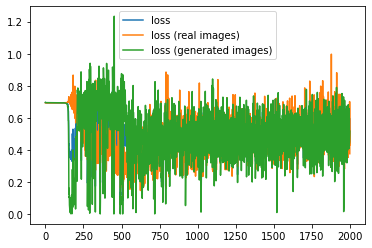

In [13]:
# Plot discriminator losses
plt.plot([row[0] for row in generative_adversarial_network.discriminator_losses], label="loss")
plt.plot([row[1] for row in generative_adversarial_network.discriminator_losses], label="loss (real images)")
plt.plot([row[2] for row in generative_adversarial_network.discriminator_losses], label="loss (generated images)")
plt.legend()
plt.show()

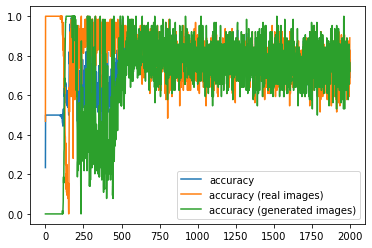

In [14]:
# Plot discriminator accuracy
plt.plot([row[3] for row in generative_adversarial_network.discriminator_losses], label="accuracy")
plt.plot([row[4] for row in generative_adversarial_network.discriminator_losses], label="accuracy (real images)")
plt.plot([row[5] for row in generative_adversarial_network.discriminator_losses], label="accuracy (generated images)")
plt.legend()
plt.show()

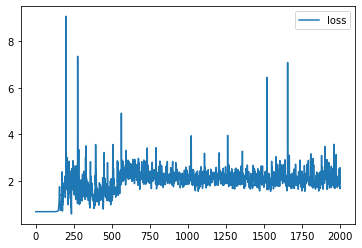

In [15]:
# Plot generator loss
plt.plot([row[0] for row in generative_adversarial_network.generator_losses], label="loss")
plt.legend()
plt.show()

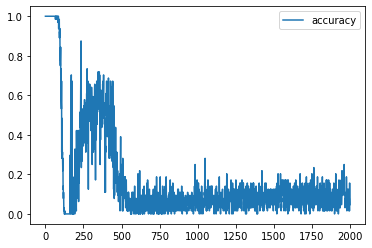

In [16]:
# Plot generator accuracy
plt.plot([row[1] for row in generative_adversarial_network.generator_losses], label="accuracy")
plt.legend()
plt.show()

### Save Model

In [17]:
generative_adversarial_network.save()

### Load Pre-Trained Model

In [18]:
# variational_autoencoder.load_weights()

### Predictions

In [19]:
def modifier_vector(size, dim, value):
    v = np.zeros(shape=(1,size))
    v[dim] = value
    return v

In [20]:
NB_PRED = 5

latent_vector_init = np.random.random(size=(1,LATENT_DIM))

latent_vectors = tf.data.Dataset.from_tensor_slices([latent_vector_init + modifier_vector(LATENT_DIM, 0, i) for i in range(NB_PRED)])

# list(latent_vectors.as_numpy_iterator())

In [21]:
latent_vectors

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 100), dtype=tf.float64, name=None)>

In [ ]:
def l1_compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

def find_closest(img):
    closest = None
    closest_l1 = None
    for i in X_train:
        l1 = l1_compare_images(img, i)
        if closest_l1 is None or l1 < closest_l1:
            closest = i
            closest_l1 = l1
    for i in X_test:
        l1 = l1_compare_images(img, i)
        if closest_l1 is None or l1 < closest_l1:
            closest = i
            closest_l1 = l1
    return closest, closest_l1

In [22]:
predictions = generative_adversarial_network.generator.predict(latent_vectors)

closest_in_dataset = []
latent_vectors_iterator = iter(latent_vectors)
for i in range(NB_PRED):
    closest_in_dataset.append(find_closest(predictions[i]))
    plt.figure(figsize=((5,5)))
    plt.subplot(1,2,1)
    plt.imshow(predictions[i], cmap="gray")
    plt.title(f"{latent_vectors_iterator.get_next()}")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(closest_in_dataset[i][0], cmap="gray")
    plt.title(f"l1 = {closest_in_dataset[i][1]}")
    plt.axis("off")

5/5 [==============================] - 0s 8ms/step


GANs are notoriously hard to train because:
- The losses can oscillate leading to bad results. This is called **Oscillating Loss**.
- The generator can find a small number of samples that fool the discriminator (called *modes*), it starts to map every point in the latent space to this observation and the gradient of the loss function collapses to 0 preventing it to learn properly (even if we train the discriminator in a way it is not fooled anymore by these observations, the generator has become numb and will simply find other modes). This phenomenon is know as **Mode Collapse**.
- The lack of correlation between the generator loss and the image quality makes the GAN hard to train. The generator is graded against a discriminator that improves overtime so the loss can increase while the image quality improves. GANs use an **Uninformative Loss**.
- GANs uses a lot of **Hyperparameters** that require fine-tuning.

In order to counter some of those effects, some improvements can be made to the basic GAN architecture. For instance the Wasserstein GAN is an attempt a improving GANs.